# Neural Networks for Eddy Covarinace

In [1]:
## Import some standard packages and define a few functions
import os
# Hide default info, logs, and warnings - comment out if you need to troubleshoot
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import shutil
import importlib
import numpy as np
import pandas as pd
# from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from Scripts import PlotHelpers
# from matplotlib.colors import Normalize
from Scripts import ReadDB, MiscFuncs, NNetFuncs

dbNames = {
    'Clean/SecondStage/TA_1_1_1':'T air',
    'Clean/SecondStage/RH_1_1_1':'RH',
    'Clean/SecondStage/FC':'FCO2',
    'Clean/SecondStage/FCH4':'FCH4',
    'Clean/SecondStage/PPFD_IN_1_1_1':'PPFD',
    'Clean/SecondStage/P_1_1_1':'Precip',
    'Flux/qc_co2_flux':'qc_FCO2',
    'Flux/qc_ch4_flux':'qc_FCH4',
    'Clean/SecondStage/USTAR':'u*',
    'Clean/SecondStage/TS_1':'T soil 5cm',
    'Clean/SecondStage/TS_2':'T soil 10cm',
    'Clean/SecondStage/TS_3':'T soil 30cm',
    'Clean/SecondStage/wind_speed':'Wind speed',
    'Clean/SecondStage/wind_dir':'Wind dir',
    'Clean/SecondStage/WTD_1_1_1':'Water table',
}

Local = '/mnt/c/Users/User/PostDoc_Work/database/'
Remote = '/mnt/w/'

Dir = Local

Site = 'BB'

read_new = True
if read_new == True:
    Data = ReadDB.get_Traces(Site,list(dbNames.keys()),Dir=Dir)
    Data = Data.rename(columns=dbNames)
    Data.to_csv(f'temp/{Site}_Data.csv')

else:
    Data = pd.read_csv(f'temp/{Site}_Data.csv',parse_dates=['TimeStamp'],index_col='TimeStamp')



## Pre-processing

In [2]:
importlib.reload(ReadDB)

Data['VPD'] = MiscFuncs.Calc_VPD(Data['TA'],Data['RH'])
Data['DOY'] = Data.index.dayofyear

target = ['FCO2','FCH4']

Data['Rand']=np.random.random(Data['FCO2'].values.shape)

print(Data[['FCO2','FCH4']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
filter.dir_mask('dir',[[0,30],[330,360]])
filter.rain('P',thresh=1)
filter.MAD(z=7)
filter.uStar('USTAR',u_thresh=0.1)

Data[['FCO2_Clean','FCH4_Clean']] = filter.df[['FCO2','FCH4']].copy()

print(Data[['FCO2_Clean','FCH4_Clean']].describe())

excludes = ['fco2','fch4']

Full_inputs = []

for val in list(Data.columns):
    exct = 0
    for ex in excludes:
        if ex in val.lower():
            exct += 1
    if exct < 1:
        Full_inputs.append(val)

Full_inputs

               FCO2          FCH4
count  33385.000000  32951.000000
mean      -0.457040     49.597336
std        3.770148     66.645355
min      -45.689865   -198.555832
25%       -1.767280      8.693725
50%       -0.121570     29.436230
75%        0.718945     87.813492
max       49.698837    695.056885
         FCO2_Clean    FCH4_Clean
count  14123.000000  10777.000000
mean      -0.828791     20.652699
std        1.605370     17.728533
min       -3.887600    -63.525269
25%       -2.137111      7.688650
50%       -0.834086     16.143156
75%        0.417498     31.751116
max        4.002227     64.322365


['TA',
 'RH',
 'PPFD',
 'P',
 'USTAR',
 'TS 5cm',
 'TS 10cm',
 'TS 30cm',
 'U',
 'dir',
 'WTD',
 'VPD',
 'DOY',
 'Rand']

# Make Scenarios

In [3]:
def Configure_Run(run,name,df,Base='',layers=1,m=5):
    run['config']['Name']=name
    run['config']['Base']=Base

    # Nodes / layer = the number of inputs times a multiplier, defaults to m=5
    Nodes = [m*len(run['config']['inputs']) for l in range(layers)]
    run['config']['Nodes']=Nodes
    run['config']['Activation']=['relu' for l in Nodes]
    run['config']['epochs']=250

    # Set to 0 for no pruning - Higher values = more strict pruning 
    run['config']['Prune_scale']=2
    
    run['config']['Norm']=True
    run['config']['RF_comp']=False
    run['config']['validation_split']=.25
    run['config']['patience']=3
    run['config']['N_models']=10

    run['Training'] = {}
    run['Evaluation'] = {}

    target = Model_Runs[key]['config']['target']
    inputs = Model_Runs[key]['config']['inputs']
    Model_Runs[key]['config']['mean'] = df[inputs].mean().values
    Model_Runs[key]['config']['variance'] = df[inputs].std().values**2
    df = df.loc[df[target+inputs].dropna().index].copy()
    if 'Mask' in Model_Runs[key]['config']:
        Training,Validation = MiscFuncs.makeSplit(df,Mask=Model_Runs[key]['config']['Mask'],return_Full=True)
    else:
        Training,Validation = MiscFuncs.makeSplit(df,dropOut=Model_Runs[key]['config']['validation_split'])
    print(Training[target+inputs].shape,Validation[target+inputs].shape)
    Model_Runs[key]['Training']['X'] = Training[inputs].values
    Model_Runs[key]['Training']['Y'] = Training[target].values.flatten()
    Model_Runs[key]['Evaluation']['X'] = Validation[inputs].values
    Model_Runs[key]['Evaluation']['Y'] = Validation[target].values.flatten()

    # Larger batch > runs faster > but won't fit as well
    batch = np.ceil(Model_Runs[key]['Training']['Y'].shape[0]*.01)
    if batch<32:
        batch=32
    run['config']['batch_size']=int(batch)

    return(run)    

Model_Runs = {
    'Full_Model':{
        'config':{
            'target':['FCO2_Clean'],
            'inputs':Full_inputs,
            },
        },
}

for key in Model_Runs.keys():
    print(key)
    Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base='Test')
Model_Runs[key]['config']

Full_Model
(10570, 15) (3523, 15)


{'target': ['FCO2_Clean'],
 'inputs': ['TA',
  'RH',
  'PPFD',
  'P',
  'USTAR',
  'TS 5cm',
  'TS 10cm',
  'TS 30cm',
  'U',
  'dir',
  'WTD',
  'VPD',
  'DOY',
  'Rand'],
 'Name': 'Full_Model',
 'Base': 'Test',
 'Nodes': [70],
 'Activation': ['relu'],
 'epochs': 250,
 'Prune_scale': 2,
 'Norm': True,
 'RF_comp': False,
 'validation_split': 0.25,
 'patience': 3,
 'N_models': 10,
 'mean': array([1.05914688e+01, 8.45259781e+01, 2.17713760e+02, 6.54291734e-02,
        1.64241463e-01, 1.15897694e+01, 1.14355001e+01, 1.12391300e+01,
        1.51118171e+00, 1.68358032e+02, 6.34482155e+01, 2.74992728e+00,
        1.83083524e+02, 5.01421670e-01]),
 'variance': array([4.82479309e+01, 2.44342428e+02, 1.29616722e+05, 6.87984209e-02,
        1.34844746e-02, 2.71218554e+01, 2.53605397e+01, 1.30344353e+01,
        1.33950994e+00, 6.91920945e+03, 1.05928283e+02, 1.52296638e+01,
        1.11123164e+04, 8.33925894e-02]),
 'batch_size': 106}

## Build and train model

In [4]:
importlib.reload(NNetFuncs)

Run = 'Full_Model'

def Build_Train_Eval(Run,print_sum=False):

    config = Run['config']
    Training = Run['Training']

    NNetFuncs.make_Dense_model(config,print_sum=print_sum)
    NNetFuncs.train_model(config,Training)
    
    Eval = Run['Evaluation']
    _=NNetFuncs.run_Model(config,Eval)



# Evaluate and prune the model

In [17]:
importlib.reload(NNetFuncs)

key='Full_Model'
Base = Model_Runs[key]['config']['Base']
Drop_Thresh_Scale = Model_Runs[key]['config']['Base']

Continue_Prune = Model_Runs[key]['config']['Prune_scale']
T1 = time.time()
while Continue_Prune > 0:
    RI = NNetFuncs.Prune(Base,key,Verbose=True,Prune_Scale=Continue_Prune)
    Pruned_Inputs = list(RI.loc[RI['Drop']==0].index)
    if len(Pruned_Inputs)<len(Model_Runs[key]['config']['inputs'])-1:
        key = 'Pruned_Model'
        Model_Runs[key]={
                'config':{
                    'target':['FCO2_Clean'],
                    'inputs':Pruned_Inputs+['Rand']
                    },
                }

        print('Pruned inputs: ',Model_Runs[key]['config']['inputs'][:-1],'\n\n')
        Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base)
        Build_Train_Eval(Model_Runs[key])
    else:
        Continue_Prune = 0
        key = 'Final_Model'
        Model_Runs[key]={
                'config':{
                    'target':['FCO2_Clean'],
                    'inputs':Pruned_Inputs
                    },
                }

        print('Final inputs: ',Model_Runs[key]['config']['inputs'][:-1],'\n\n')
        Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base)
        Build_Train_Eval(Model_Runs[key],print_sum=True)
        shutil.rmtree(f'Models/{Base}/Pruned_Model')
T2 = time.time()

print("Pruning Time: ", T2-T1)

         RI_bar  RI_CI95  lower_bound  upper_bound  Drop
Rand       0.03     0.00         0.03         0.03  0.88
dir        0.40     0.03         0.37         0.43  0.88
P          0.67     0.08         0.59         0.75  0.88
U          0.83     0.09         0.75         0.92  0.88
RH         0.85     0.16         0.69         1.01  0.88
TA         0.92     0.14         0.78         1.06  0.88
USTAR      1.00     0.09         0.91         1.10  0.00
WTD        1.27     0.12         1.15         1.38  0.00
VPD        1.68     0.26         1.42         1.94  0.00
TS 5cm     2.93     0.87         2.06         3.79  0.00
TS 10cm    3.47     0.86         2.61         4.33  0.00
DOY        6.66     0.54         6.11         7.20  0.00
TS 30cm   12.63     0.88        11.75        13.51  0.00
PPFD      66.67     2.85        63.82        69.52  0.00
Pruned inputs:  ['USTAR', 'WTD', 'VPD', 'TS 5cm', 'TS 10cm', 'DOY', 'TS 30cm', 'PPFD'] 


(10570, 10) (3523, 10)
Training Time:
 148.76  Seconds


Inspect pruned model

NN Model
 Validation metrics (ensemble mean): 
r2 =  0.86978 
RMSE =  0.58452
Run Time:
 0.59  Seconds
10 models
Mean epochs/model:  66.1
         RI_bar  RI_CI95
TS 10cm    5.85     0.67
TS 30cm   11.78     1.30
DOY       16.89     1.65
PPFD      65.48     2.72


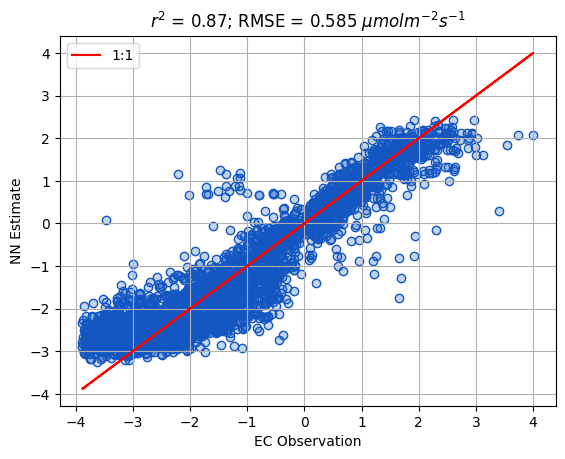

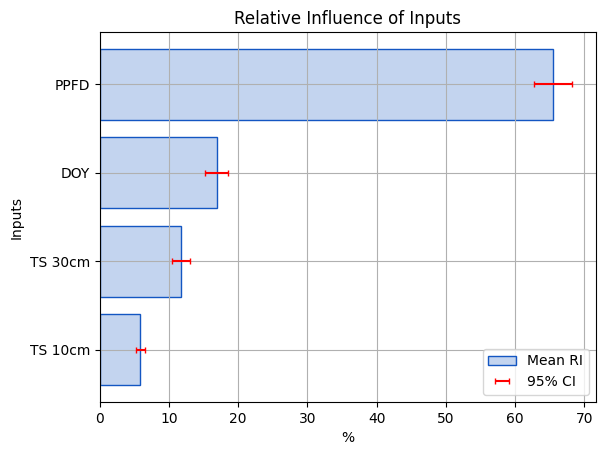

In [6]:
importlib.reload(PlotHelpers)

config = Model_Runs[key]['config']
Eval = Model_Runs[key]['Evaluation']
full_out=NNetFuncs.run_Model(config,Eval)
# print('\n\n')

Base = Model_Runs[key]['config']['Base']
Name = Model_Runs[key]['config']['Name']


# run = 'Feature_Detection'
unit = '$\mu mol m^{-2} s^{-1}$'

df = pd.read_csv(f'Models/{Base}/{Name}/model_output.csv',index_col=[0])

fig,ax=plt.subplots()
ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
ax.set_ylabel('NN Estimate')
ax.set_xlabel('EC Observation')
 
RI = pd.read_csv(f'Models/{Base}/{Name}/model_RI.csv',index_col=[0])

RI = RI.sort_values(by=f'RI_bar',ascending=True)
fig,ax=plt.subplots()
PlotHelpers.makeRI_plot(ax,RI)

# RI['Thresh'] = RI['RI_bar']-RI['RI_CI95']
print(RI.round(2))


PPFD
DOY
TS 30cm
TS 10cm


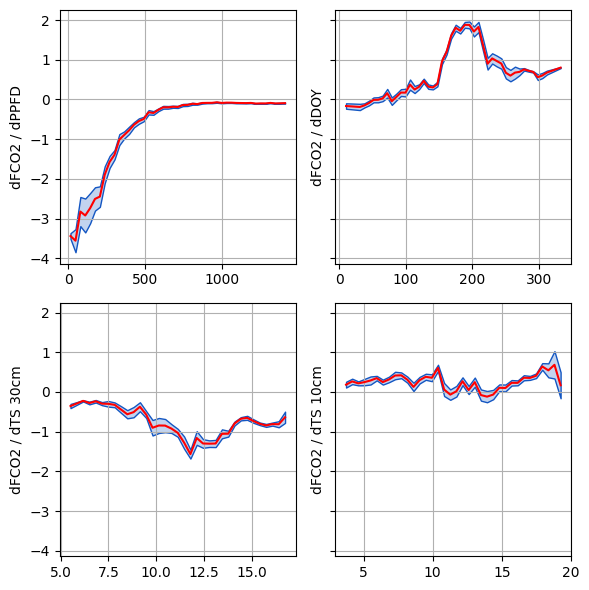

In [7]:

Max=4
Top = RI.sort_values(by=f'RI_bar',ascending=False).index[:Max]

cols = 2
npi=len(RI.index)
rows = int(np.ceil(len(Top)/2))

fig,axes=plt.subplots(rows,cols,sharey=True,
                      figsize=(6,6))

axes = axes.flatten()

mod = '_norm'

for i,xi in enumerate(Top):
    print(xi)
    df_int = MiscFuncs.byInterval(df,f'{xi}',[f'dy_d{xi}{mod}'],bins=50)
    PlotHelpers.CI_Plot(axes[i],df_int,f'dy_d{xi}{mod}')
plt.tight_layout()

axes[i].get_ylabel()

for ax in axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l.split('_norm')[0].replace('_',' / ').replace('y','FCO2'))

In [8]:

# df = pd.read_csv(f'Models/{run}/random_forest_output.csv',index_col=[0])

# unit = ''

# fig,ax=plt.subplots()
# ax.scatter(df['target'],df['y_bar'])
# ax.plot(df['target'],df['target'],color='k')
# r2 = np.round(metrics.r2_score(df['target'],df['y_bar']),2)
# RMSE = np.round(metrics.mean_squared_error(df['target'],df['y_bar'])**.5,2)
# ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
# ax.set_ylabel('NN Estimate')
# ax.set_xlabel('EC Observation')

# RF_RI = pd.read_csv(f'Models/{run}/random_forest_RI.csv',index_col=[0])

# mod = ''

# RF_RI = RF_RI.sort_values(by = f'RI{mod}_bar')

# fig,ax=plt.subplots()
# ax.barh(RF_RI.index,RF_RI[f'RI{mod}_bar'],xerr=RF_RI[f'RI{mod}_CI95'])
# ax.grid()
# ax.set_xscale('log')

# RF_RI

In [9]:
# NN_RI = pd.read_csv(f'{run}/model_RI.csv',index_col=[0])
# mod = '_norm'

# NN_RI = NN_RI.sort_values(by=f'RI{mod}_bar',ascending=True)
# fig,ax=plt.subplots()

# ax.barh(NN_RI.index,NN_RI[f'RI{mod}_bar'],yerr=NN_RI[f'RI{mod}_CI95'])
# ax.grid()


In [10]:
# RF_Output = pd.read_csv(f'{run}/random_forest_output.csv',index_col=[0])

# RF_Output.head()